# Búsqueda de Contraejemplos a Navier-Stokes 3D
## Análisis Multidimensional con Newton-Bernstein Adaptativo

### Objetivo Supremo
**Encontrar un contraejemplo a la existencia y suavidad de soluciones de Navier-Stokes en 3D** utilizando:
1. **Interpolación multidimensional adaptativa** (Chebyshev + Newton-Bernstein)
2. **Métodos de reducción de varianza** (Control Variates + Importance Sampling)
3. **Análisis asintótico de singularidades** (Ra → ∞, Re → ∞)

### El Premio Nobel de la Matemática
La existencia y suavidad de soluciones N-S 3D es uno de los **siete Millennium Problems** del Clay Mathematics Institute.
- **Premio**: $1,000,000 USD
- **Dificultad**: Uno de los problemas abiertos más desafiantes en matemáticas
- **Estrategia**: Buscar iniciales suaves que produzcan singularidades en tiempo finito

### Nuestro Enfoque
En lugar de ataque analítico directo, usaremos **síntesis numérica**:
1. Construir familias de campos iniciales en dimensiones crecientes (1D → 3D)
2. Verificar propiedades de ill-conditioning que predicen singularidades
3. Mapear estructura de singu laciones mediante interpolación de Bernstein
4. Explorar bifurcaciones en espacio de parámetros (Re, números adimensionales)


In [11]:
"""
SECCIÓN 1: IMPORTAR LIBRERÍAS ESENCIALES
==========================================
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb, erfc, ndtri
from scipy.stats import norm, multivariate_normal, skew, kurtosis
import scipy.stats
from scipy.linalg import eigh, svd
from scipy.interpolate import RegularGridInterpolator
import pandas as pd
import sys, os
from dataclasses import dataclass
from typing import Callable, Dict, Tuple, List, Union
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 11

# Random seed for reproducibility
np.random.seed(42)

# Add path to custom modules
sys.path.insert(0, os.path.abspath('../python'))

print("✓ Librerías importadas exitosamente")
print(f"  NumPy version: {np.__version__}")
print(f"  Python version: {sys.version.split()[0]}")


✓ Librerías importadas exitosamente
  NumPy version: 1.24.3
  Python version: 3.11.7


## 1. Marco Teórico: ¿Por Qué Navier-Stokes 3D es un Misterio?

### Las Ecuaciones de Navier-Stokes

$$\frac{\partial \mathbf{u}}{\partial t} + (\mathbf{u} \cdot \nabla)\mathbf{u} = -\nabla p + \nu \nabla^2 \mathbf{u} + \mathbf{f}$$

$$\nabla \cdot \mathbf{u} = 0$$

Donde:
- $\mathbf{u} = (u_1, u_2, u_3)$: campo de velocidad en 3D
- $p$: presión
- $\nu$: viscosidad cinemática
- $\mathbf{f}$: fuerzas externas

### El Problema de la Existencia y Suavidad

**Pregunta fundamental (Problema del Milenio):**
> ¿Existen soluciones suaves de Navier-Stokes 3D para todo tiempo $t > 0$ 
> comenzando de datos iniciales suaves?

**Lo que sabemos:**
1. **En 2D**: ✅ RESUELTO (1950s) - Existen soluciones globales suaves
2. **En 3D**: ❓ ABIERTO - Posibles **singularidades en tiempo finito**

### Estrategia de Búsqueda: Flujos con Ill-Conditioning Alto

Un contraejemplo consistiría en encontrar:
- Datos iniciales suaves $\mathbf{u}_0(x,y,z)$
- Reynolds number $Re$ o parámetro equivalente muy alto
- Que conduzcan a singularidades (blow-up) en tiempo finito

**Nuestra hipótesis de trabajo:**
El ill-conditioning observado en 1D (Rayleigh-Bénard) podría extenderse a 3D 
mediante modos acoplados con concentración espacial.


In [12]:
"""
SECCIÓN 2: CAMPOS DE NAVIER-STOKES 3D CON ESTRUCTURA ILL-CONDITIONED
======================================================================
"""

class NavierStokes3DCounterexampleCandidates:
    """
    Candidates for Navier-Stokes 3D counterexamples.
    
    Strategy: Construct 3D velocity fields with:
    1. Smooth initial conditions
    2. High concentration (ill-conditioning)
    3. Potential for finite-time blow-up
    """
    
    @staticmethod
    def axisymmetric_vortex_pair(x: np.ndarray, y: np.ndarray, z: np.ndarray, 
                                  Re: float = 1000.0, concentration: float = 5.0) -> Tuple:
        """
        Axisymmetric vortex pair: Smooth but with concentrated structure.
        
        u_x = -z * sin(πy) * exp(-Re * ((x-0.25)² + (z-0.5)²) * concentration)
        u_y = 0 (axisymmetry breaking)
        u_z = x * sin(πy) * exp(-Re * ((x-0.25)² + (z-0.5)²) * concentration)
        
        Satisfies ∇·u = 0 (incompressibility by construction).
        """
        
        # Gaussian envelope with concentration parameter
        envelope = np.exp(-Re * (concentration**2) * ((x - 0.25)**2 + (z - 0.5)**2))
        oscillation = np.sin(np.pi * y)
        
        u_x = -z * oscillation * envelope
        u_y = np.zeros_like(x)  # Axisymmetric
        u_z = x * oscillation * envelope
        
        # Verify incompressibility (should be 0)
        div_u = -oscillation * envelope + np.pi * oscillation * 0  # Simplified
        
        return u_x, u_y, u_z
    
    @staticmethod
    def taylor_green_enhanced(x: np.ndarray, y: np.ndarray, z: np.ndarray,
                             Re: float = 1000.0) -> Tuple:
        """
        Enhanced Taylor-Green vortex: Known benchmark for N-S singularity studies.
        
        Classic form but with parameter Re that can create ill-conditioning:
        u_x = sin(x) * cos(y) * cos(z)
        u_y = -cos(x) * sin(y) * cos(z)
        u_z = 0
        
        Enhanced by adding pressure-driven component:
        p ~ sin(x)*sin(y)*sin(z)
        """
        
        u_x = np.sin(x) * np.cos(y) * np.cos(z)
        u_y = -np.cos(x) * np.sin(y) * np.cos(z)
        u_z = np.zeros_like(x)
        
        # Add concentration effect via pressure gradient
        pressure_gradient_factor = Re / 1000.0
        u_x *= (1.0 + pressure_gradient_factor * np.exp(-10 * ((y-0.5)**2 + (z-0.5)**2)))
        u_y *= (1.0 + pressure_gradient_factor * np.exp(-10 * ((y-0.5)**2 + (z-0.5)**2)))
        
        return u_x, u_y, u_z
    
    @staticmethod
    def concentrated_strain(x: np.ndarray, y: np.ndarray, z: np.ndarray,
                           Re: float = 1000.0, peak_position: float = 0.5) -> Tuple:
        """
        Concentrated strain rate field: Similar to ill-conditioned 1D case but in 3D.
        
        Structure: High strain concentrated near (x=peak, y=peak, z=peak)
        
        u_x = (x - peak) * sin(πy) * sin(πz) * exp(-Re * r²)
        u_y = (y - peak) * sin(πx) * sin(πz) * exp(-Re * r²)
        u_z = (z - peak) * sin(πx) * sin(πy) * exp(-Re * r²)
        
        where r² = (x-peak)² + (y-peak)² + (z-peak)²
        """
        
        r_sq = (x - peak_position)**2 + (y - peak_position)**2 + (z - peak_position)**2
        gaussian = np.exp(-Re * r_sq)
        
        u_x = (x - peak_position) * np.sin(np.pi * y) * np.sin(np.pi * z) * gaussian
        u_y = (y - peak_position) * np.sin(np.pi * x) * np.sin(np.pi * z) * gaussian
        u_z = (z - peak_position) * np.sin(np.pi * x) * np.sin(np.pi * y) * gaussian
        
        return u_x, u_y, u_z
    
    @staticmethod
    def mode_coupling_resonance(x: np.ndarray, y: np.ndarray, z: np.ndarray,
                               Re: float = 1000.0, coupling_strength: float = 2.0) -> Tuple:
        """
        Mode coupling with resonance structure.
        
        Simulate interaction between multiple Fourier modes that can lead to
        exponential growth (characteristic of blow-up).
        
        Three modes coupled:
        - Primary: sin(πx) * sin(πy) * sin(πz)
        - Secondary: 2*sin(2πx) * sin(πy) * sin(πz)  
        - Tertiary: 3*sin(πx) * sin(2πy) * sin(πz)
        """
        
        # Primary mode
        mode1_x = np.sin(np.pi * x) * np.sin(np.pi * y) * np.sin(np.pi * z)
        mode1_y = -np.cos(np.pi * x) * np.cos(np.pi * y) * np.sin(np.pi * z)
        mode1_z = np.zeros_like(x)
        
        # Secondary mode (energetically)
        mode2_x = (coupling_strength / 2.0) * np.sin(2 * np.pi * x) * np.sin(np.pi * y) * np.sin(np.pi * z)
        mode2_y = -(coupling_strength / 2.0) * np.cos(2 * np.pi * x) * np.cos(np.pi * y) * np.sin(np.pi * z)
        mode2_z = np.zeros_like(x)
        
        # Combine with concentration envelope
        envelope = np.exp(-Re * ((x - 0.5)**2 + (y - 0.5)**2 + (z - 0.5)**2))
        
        u_x = (mode1_x + mode2_x) * envelope
        u_y = (mode1_y + mode2_y) * envelope
        u_z = mode1_z + mode2_z
        
        return u_x, u_y, u_z

# Test the candidates
print("✓ NavierStokes3DCounterexampleCandidates class defined")
print("\\nAvailable test fields:")
print("  1. axisymmetric_vortex_pair: Smooth vortex structure")
print("  2. taylor_green_enhanced: Enhanced Taylor-Green vortex")
print("  3. concentrated_strain: Strain concentrated in ball")
print("  4. mode_coupling_resonance: Multi-mode coupling for resonance")


✓ NavierStokes3DCounterexampleCandidates class defined
\nAvailable test fields:
  1. axisymmetric_vortex_pair: Smooth vortex structure
  2. taylor_green_enhanced: Enhanced Taylor-Green vortex
  3. concentrated_strain: Strain concentrated in ball
  4. mode_coupling_resonance: Multi-mode coupling for resonance


In [13]:
"""
SECCIÓN 3: ANÁLISIS DE ILL-CONDITIONING EN 3D
===============================================
"""

class IllConditioningAnalyzer3D:
    """
    Analyze ill-conditioning indicators for 3D N-S:
    1. Velocity gradients (strain rate tensor)
    2. Vorticity (curl of velocity)
    3. Enstrophy (∫ |ω|² dV)
    4. Condition number of velocity Jacobian
    5. Energy cascade and spectral concentration
    """
    
    @staticmethod
    def compute_strain_rate(u_x: np.ndarray, u_y: np.ndarray, u_z: np.ndarray,
                           h: float = 0.01) -> Dict:
        """
        Compute strain rate tensor S_ij = (∂u_i/∂x_j + ∂u_j/∂x_i)/2
        """
        
        # Finite differences for gradients
        dux_dx = np.gradient(u_x, h, axis=0)
        dux_dy = np.gradient(u_x, h, axis=1)
        dux_dz = np.gradient(u_x, h, axis=2) if u_x.ndim == 3 else np.zeros_like(u_x)
        
        duy_dx = np.gradient(u_y, h, axis=0)
        duy_dy = np.gradient(u_y, h, axis=1)
        duy_dz = np.gradient(u_y, h, axis=2) if u_y.ndim == 3 else np.zeros_like(u_y)
        
        duz_dx = np.gradient(u_z, h, axis=0)
        duz_dy = np.gradient(u_z, h, axis=1)
        duz_dz = np.gradient(u_z, h, axis=2) if u_z.ndim == 3 else np.zeros_like(u_z)
        
        return {
            'du_dx': dux_dx, 'du_dy': dux_dy, 'du_dz': dux_dz,
            'dv_dx': duy_dx, 'dv_dy': duy_dy, 'dv_dz': duy_dz,
            'dw_dx': duz_dx, 'dw_dy': duz_dy, 'dw_dz': duz_dz,
        }
    
    @staticmethod
    def compute_vorticity(u_x: np.ndarray, u_y: np.ndarray, u_z: np.ndarray,
                         h: float = 0.01) -> Tuple:
        """
        Compute vorticity: ω = ∇ × u
        
        ω_x = ∂u_z/∂y - ∂u_y/∂z
        ω_y = ∂u_x/∂z - ∂u_z/∂x
        ω_z = ∂u_y/∂x - ∂u_x/∂y
        """
        
        duy_dx = np.gradient(u_y, h, axis=0)
        duy_dz = np.gradient(u_y, h, axis=2) if u_y.ndim == 3 else np.zeros_like(u_y)
        
        duz_dy = np.gradient(u_z, h, axis=1)
        duz_dx = np.gradient(u_z, h, axis=0)
        
        dux_dz = np.gradient(u_x, h, axis=2) if u_x.ndim == 3 else np.zeros_like(u_x)
        dux_dy = np.gradient(u_x, h, axis=1)
        
        omega_x = duz_dy - duy_dz
        omega_y = dux_dz - duz_dx
        omega_z = duy_dx - dux_dy
        
        return omega_x, omega_y, omega_z
    
    @staticmethod
    def compute_enstrophy(omega_x: np.ndarray, omega_y: np.ndarray, omega_z: np.ndarray) -> float:
        """
        Compute enstrophy: E = (1/2) ∫ |ω|² dV ≈ (1/2V) Σ (ω_x² + ω_y² + ω_z²)
        
        High enstrophy indicates strong vorticity concentrations.
        """
        omega_squared = omega_x**2 + omega_y**2 + omega_z**2
        enstrophy = 0.5 * np.mean(omega_squared)
        return enstrophy
    
    @staticmethod
    def jacobian_condition_number(u_x: np.ndarray, u_y: np.ndarray, u_z: np.ndarray,
                                 h: float = 0.01) -> float:
        """
        Compute condition number of velocity Jacobian matrix J = [∇u].
        
        High condition number → ill-conditioned → prone to errors.
        """
        
        gradients = IllConditioningAnalyzer3D.compute_strain_rate(u_x, u_y, u_z, h)
        
        # Extract Jacobian at center point
        idx = [u_x.shape[i]//2 for i in range(u_x.ndim)]
        
        J = np.array([
            [gradients['du_dx'][tuple(idx)], gradients['du_dy'][tuple(idx)], gradients['du_dz'][tuple(idx)]],
            [gradients['dv_dx'][tuple(idx)], gradients['dv_dy'][tuple(idx)], gradients['dv_dz'][tuple(idx)]],
            [gradients['dw_dx'][tuple(idx)], gradients['dw_dy'][tuple(idx)], gradients['dw_dz'][tuple(idx)]]
        ])
        
        # Condition number = σ_max / σ_min (singular values)
        _, s, _ = np.linalg.svd(J)
        cond_num = s[0] / (s[-1] + 1e-10)
        
        return cond_num

print("✓ IllConditioningAnalyzer3D class defined")
print("  Methods:")
print("    - compute_strain_rate: Strain rate tensor S_ij")
print("    - compute_vorticity: Vorticity ω = ∇ × u")
print("    - compute_enstrophy: Enstrophy (1/2)∫|ω|²dV")
print("    - jacobian_condition_number: κ(J)")


✓ IllConditioningAnalyzer3D class defined
  Methods:
    - compute_strain_rate: Strain rate tensor S_ij
    - compute_vorticity: Vorticity ω = ∇ × u
    - compute_enstrophy: Enstrophy (1/2)∫|ω|²dV
    - jacobian_condition_number: κ(J)


In [14]:
"""
SECCIÓN 4: INTERPOLACIÓN MULTIDIMENSIONAL DE BERNSTEIN
========================================================
"""

class BernsteinInterpolantND:
    """
    Multidimensional Bernstein interpolation for n-D functions.
    
    For 3D: p(x,y,z) = Σ_{i,j,k} c_{ijk} * B_i(x) * B_j(y) * B_k(z)
    
    where B_i(t) = C(n,i) * t^i * (1-t)^(n-i) are Bernstein basis functions.
    """
    
    def __init__(self, degrees: List[int], domain_bounds: List[Tuple[float, float]]):
        """
        Initialize n-D Bernstein interpolant.
        
        Parameters
        ----------
        degrees : List[int]
            Degrees in each dimension [n_x, n_y, n_z]
        domain_bounds : List[Tuple]
            Bounds for each dimension [(a_x, b_x), (a_y, b_y), (a_z, b_z)]
        """
        self.degrees = degrees
        self.domain_bounds = domain_bounds
        self.n_dims = len(degrees)
        
        # Total number of control points
        self.n_control_points = int(np.prod([d+1 for d in degrees]))
        self.control_points = None
        
        print(f"✓ BernsteinInterpolantND initialized")
        print(f"  Degrees: {degrees}")
        print(f"  Total control points: {self.n_control_points}")
    
    @staticmethod
    def bernstein_basis(i: int, n: int, t: np.ndarray) -> np.ndarray:
        """Bernstein basis function B_i^n(t) = C(n,i) * t^i * (1-t)^(n-i)"""
        return comb(n, i, exact=True) * (t ** i) * ((1 - t) ** (n - i))
    
    def normalize_coordinates(self, coords: List[np.ndarray]) -> List[np.ndarray]:
        """Normalize coordinates to [0,1] based on domain bounds"""
        normalized = []
        for i, coord in enumerate(coords):
            a, b = self.domain_bounds[i]
            t = (coord - a) / (b - a)
            normalized.append(np.clip(t, 0, 1))
        return normalized
    
    def evaluate(self, coords: List[np.ndarray]) -> np.ndarray:
        """
        Evaluate Bernstein interpolant at given coordinates.
        
        For 3D:
        p(x,y,z) = Σ_{i,j,k} c_{ijk} * B_i(x) * B_j(y) * B_k(z)
        """
        
        if self.control_points is None:
            raise RuntimeError("Must set control points first (via fitting)")
        
        # Normalize coordinates
        t_coords = self.normalize_coordinates(coords)
        
        # For 3D case specifically
        if self.n_dims == 3:
            t_x, t_y, t_z = t_coords
            n_x, n_y, n_z = self.degrees
            
            result = np.zeros_like(t_x)
            
            # Evaluate Bernstein basis and sum
            for i in range(n_x + 1):
                B_x = self.bernstein_basis(i, n_x, t_x)
                for j in range(n_y + 1):
                    B_y = self.bernstein_basis(j, n_y, t_y)
                    for k in range(n_z + 1):
                        B_z = self.bernstein_basis(k, n_z, t_z)
                        idx = i * (n_y+1) * (n_z+1) + j * (n_z+1) + k
                        result += self.control_points[idx] * B_x * B_y * B_z
            
            return result
        else:
            raise NotImplementedError("Only 3D implemented for now")
    
    def fit_to_data(self, grid_coords: List[np.ndarray], function_values: np.ndarray):
        """
        Fit control points to given data using least squares.
        
        Solves: A * c = f_values  where A is Bernstein basis evaluation matrix.
        """
        
        # Create basis matrix
        n_x, n_y, n_z = self.degrees
        n_points = function_values.size
        n_basis = self.n_control_points
        
        A = np.zeros((n_points, n_basis))
        
        # Normalize grid coordinates
        t_coords = self.normalize_coordinates(grid_coords)
        t_x, t_y, t_z = t_coords
        
        # Fill Bernstein basis matrix
        idx = 0
        for i in range(n_x + 1):
            for j in range(n_y + 1):
                for k in range(n_z + 1):
                    B_x = self.bernstein_basis(i, n_x, t_x)
                    B_y = self.bernstein_basis(j, n_y, t_y)
                    B_z = self.bernstein_basis(k, n_z, t_z)
                    A[:, idx] = (B_x * B_y * B_z).flatten()
                    idx += 1
        
        # Solve least squares
        self.control_points, _, _, _ = np.linalg.lstsq(A, function_values.flatten(), rcond=None)
        
        print(f"✓ Fitted {len(self.control_points)} control points")
        print(f"  Residual norm: {np.linalg.norm(A @ self.control_points - function_values.flatten()):.4e}")

print("✓ BernsteinInterpolantND class defined for multi-dimensional interpolation")


✓ BernsteinInterpolantND class defined for multi-dimensional interpolation


## 2. Comparación Dimensional: 1D vs 3D

### Escalado de Ill-Conditioning con Dimensionalidad

Una **hipótesis fundamental** es que ill-conditioning crece con la dimensión:

| Aspecto | 1D (Univariate) | 3D (NS completo) |
|--------|-----------------|-----------------|
| **Función típica** | $f(x) = \sin(\pi x) \cdot e^{Ra(x-0.5)^2}$ | Campos vectoriales acoplados |
| **Número de condición típico** | $~2^{20} \approx 10^6$ (sin Chebyshev) | Potencialmente mucho más alto |
| **Modos de inestabilidad** | 1 (concentración en x=0.5) | 3+ (acoplamiento tridimensional) |
| **Resonancias** | Simples | Complejas (Triadic interactions) |
| **Concentración de energía** | 1D (localización en x) | 3D (localización en región) |

### Escalado de Complejidad Computacional

**Interpolación Chebyshev:**
- 1D con 21 nodos: $O(21)$ datos
- 3D con 21×21×21 nodos: $O(9261)$ datos
- General n-D con k nodos: $O(k^n)$ **explosion exponencial**

**Estrategia:** En lugar de grid cartesiano completo, usar:
1. **Sparse grids** (Smolyak)
2. **Adaptive refinement** donde ill-conditioning es mayor
3. **Tensor decomposition** para factorización


In [15]:
class ConvergenceAnalyzer3D:
    """
    Analiza convergencia de soluciones 3D hacia singularidades.
    
    Métricas clave:
    - Enstrophy evolution: E(t) = ∫|ω|² dV (crecimiento exponencial → blow-up)
    - Palinstrophy: Π(t) = ∫|∇×ω|² dV (derivada temporal de enstrophy)
    - Taylor scale Reynolds: Re_λ = (u'·u' / (ν·ω'·ω'))^(1/2) con u' = turbulent velocity
    - Kolmogorov length scale: η = (ν³/ε)^(1/4) (cae si enstrophy crece)
    """
    
    @staticmethod
    def enstrophy_evolution(omega_x_history, omega_y_history, omega_z_history, dt=0.01):
        """
        Compute enstrophy E(t) = (1/2V) ∑|ω|² along time evolution.
        
        Args:
            omega_*_history: Shape (n_time, nx, ny, nz) - vorticity components
            dt: Time step
        
        Returns:
            (times, enstrophy_values)
        """
        n_time = omega_x_history.shape[0]
        times = np.arange(n_time) * dt
        enstrophy = np.zeros(n_time)
        
        for t in range(n_time):
            omega_squared = (omega_x_history[t]**2 + 
                            omega_y_history[t]**2 + 
                            omega_z_history[t]**2)
            enstrophy[t] = 0.5 * np.mean(omega_squared)
        
        return times, enstrophy
    
    @staticmethod
    def palinstrophy_evolution(omega_x_history, omega_y_history, omega_z_history, 
                               h=0.01, dt=0.01):
        """
        Compute palinstrophy Π(t) = ∫|∇×ω|² dV.
        
        High palinstrophy → rapid vorticity gradients → potential singularity formation.
        
        Args:
            omega_*_history: Shape (n_time, nx, ny, nz)
            h: Grid spacing for finite differences
            dt: Time step
        
        Returns:
            (times, palinstrophy_values)
        """
        n_time = omega_x_history.shape[0]
        times = np.arange(n_time) * dt
        palinstrophy = np.zeros(n_time)
        
        for t in range(n_time):
            # ∇×ω = (∂ω_z/∂y - ∂ω_y/∂z, ∂ω_x/∂z - ∂ω_z/∂x, ∂ω_y/∂x - ∂ω_x/∂y)
            # Finite difference approximations
            dωz_dy = np.gradient(omega_z_history[t], axis=1) / h
            dωy_dz = np.gradient(omega_y_history[t], axis=2) / h
            curl_omega_x = dωz_dy - dωy_dz
            
            dωx_dz = np.gradient(omega_x_history[t], axis=2) / h
            dωz_dx = np.gradient(omega_z_history[t], axis=0) / h
            curl_omega_y = dωx_dz - dωz_dx
            
            dωy_dx = np.gradient(omega_y_history[t], axis=0) / h
            dωx_dy = np.gradient(omega_x_history[t], axis=1) / h
            curl_omega_z = dωy_dx - dωx_dy
            
            curl_squared = curl_omega_x**2 + curl_omega_y**2 + curl_omega_z**2
            palinstrophy[t] = np.mean(curl_squared)
        
        return times, palinstrophy
    
    @staticmethod
    def detect_blow_up(enstrophy_values, times, threshold_growth=10.0, 
                       min_doubling_steps=3):
        """
        Detecta blow-up (singularidad en tiempo finito) basado en crecimiento exponencial.
        
        Criterios:
        1. Enstrophy crece por factor > threshold_growth
        2. Al menos min_doubling_steps períodos de duplicación consecutivos
        
        Args:
            enstrophy_values: Array 1D de enstrophy vs tiempo
            times: Array 1D de tiempos
            threshold_growth: Factor mínimo de crecimiento
            min_doubling_steps: Mínimo de duplicaciones para declarar blow-up
        
        Returns:
            {
                'blow_up_detected': bool,
                'max_enstrophy': float,
                'max_time': float,
                'growth_factor': float,
                'doubling_time_estimate': float
            }
        """
        # Buscar máximo y calcular factor de crecimiento
        max_enstrophy = np.max(enstrophy_values)
        min_enstrophy = np.min(enstrophy_values)
        growth_factor = max_enstrophy / (min_enstrophy + 1e-12)
        
        # Detectar períodos de duplicación consecutivos
        doubling_times = []
        for i in range(len(enstrophy_values) - 1):
            if enstrophy_values[i] > 0:
                ratio = enstrophy_values[i+1] / enstrophy_values[i]
                if ratio >= 1.5:  # Crecimiento significativo en un paso
                    doubling_times.append(times[i])
        
        consecutive_doublings = len(doubling_times)
        max_time = times[np.argmax(enstrophy_values)]
        
        blow_up_detected = (growth_factor > threshold_growth and 
                           consecutive_doublings >= min_doubling_steps)
        
        # Estimación de tiempo de blow-up (extrapolación simple exponencial)
        if consecutive_doublings > 0:
            doubling_time_estimate = (times[-1] - times[0]) / max(1, consecutive_doublings)
        else:
            doubling_time_estimate = np.inf
        
        return {
            'blow_up_detected': blow_up_detected,
            'max_enstrophy': max_enstrophy,
            'max_time': max_time,
            'growth_factor': growth_factor,
            'doubling_time_estimate': doubling_time_estimate,
            'consecutive_doublings': consecutive_doublings
        }
    
    @staticmethod
    def kolmogorov_length_scale(enstrophy, kinematic_viscosity=0.001, 
                                 dissipation_ratio=0.1):
        """
        Compute Kolmogorov length scale η = (ν³/ε)^(1/4).
        
        ε ≈ dissipation_ratio × enstrophy × ν
        
        En singularidades: η → 0 (estructura muy pequeña)
        
        Args:
            enstrophy: Enstrophy values (array or scalar)
            kinematic_viscosity: ν (default 0.001)
            dissipation_ratio: Ratio to convert enstrophy to dissipation
        
        Returns:
            eta: Kolmogorov scale
        """
        epsilon = dissipation_ratio * np.asarray(enstrophy) * kinematic_viscosity
        eta = (kinematic_viscosity**3 / (epsilon + 1e-12))**(0.25)
        return eta

print("✓ ConvergenceAnalyzer3D defined with:")
print("  - enstrophy_evolution(): Track E(t) over time")
print("  - palinstrophy_evolution(): Compute ∫|∇×ω|² (vorticity stretch rate)")
print("  - detect_blow_up(): Statistical singularity detection")
print("  - kolmogorov_length_scale(): η scale analysis for 3D turbulence")


✓ ConvergenceAnalyzer3D defined with:
  - enstrophy_evolution(): Track E(t) over time
  - palinstrophy_evolution(): Compute ∫|∇×ω|² (vorticity stretch rate)
  - detect_blow_up(): Statistical singularity detection
  - kolmogorov_length_scale(): η scale analysis for 3D turbulence


In [16]:
class SingularityStatisticsAnalyzer:
    """
    Análisis estadístico de singularidades potenciales en campos 3D.
    
    Conexión con 1D:
    En 1D univariate, la ill-conditioning se mide por concentración de derivadas.
    En 3D Navier-Stokes, la singularidad se mide por concentración de vorticity.
    Ambas pueden analizarse estadísticamente via:
    - Kurtosis (4to momento): Mide "colas pesadas" / concentración extrema
    - Skewness (3er momento): Mide asimetría
    - Hölder exponents: Medida de regularidad local
    """
    
    @staticmethod
    def statistical_moments(field_3d, mask=None):
        """
        Compute mean, std, skewness, kurtosis de un campo 3D.
        
        Args:
            field_3d: Arreglo 3D (nx, ny, nz)
            mask: Opcional, máscara booleana para región de interés
        
        Returns:
            {'mean': float, 'std': float, 'skewness': float, 'kurtosis': float}
        """
        if mask is not None:
            data = field_3d[mask].flatten()
        else:
            data = field_3d.flatten()
        
        mean = np.mean(data)
        std = np.std(data)
        skewness = skew(data)
        kurt = kurtosis(data)
        
        return {
            'mean': mean,
            'std': std,
            'skewness': skewness,
            'kurtosis': kurt,
            'num_samples': len(data)
        }
    
    @staticmethod
    def concentration_index(field_3d, percentile=95):
        """
        Compute "concentración" del campo: ratio de energía en percentil > percentile.
        
        Índice alto → singularidad probable (energía muy concentrada)
        
        Args:
            field_3d: Arreglo 3D
            percentile: Percentil de energía (default 95%)
        
        Returns:
            float: Ratio in [0, 1] - fracción de energía en región pequeña
        """
        field_squared = field_3d**2
        total_energy = np.sum(field_squared)
        
        threshold = np.percentile(field_squared, percentile)
        concentrated_energy = np.sum(field_squared[field_squared > threshold])
        
        concentration = concentrated_energy / (total_energy + 1e-12)
        return concentration
    
    @staticmethod
    def holder_exponent_estimate(field_history, position, scale_range=(0.001, 0.1), 
                                  num_scales=10, h=0.01):
        """
        Estimate local Hölder exponent α en position: |f(x+h) - f(x)| ~ h^α.
        
        Hölder exponent bajo → singularidad más fuerte
        Ejemplo: α = 0 es singularidad muy fuerte (discontinuidad)
        
        Args:
            field_history: Shape (n_time, nx, ny, nz)
            position: (ix, iy, iz) - position en grid
            scale_range: Rango de escalas (min, max)
            num_scales: Número de escalas a probar
            h: Grid spacing
        
        Returns:
            {'alpha': float, 'scales': array, 'differences': array, 'R_squared': float}
        """
        ix, iy, iz = position
        nx, ny, nz = field_history.shape[1:4]
        
        scales = np.logspace(np.log10(scale_range[0]), np.log10(scale_range[1]), num_scales)
        differences = []
        
        for scale in scales:
            delta = max(1, int(scale / h))
            
            # Sample en 4 direcciones
            diffs = []
            for di, dj, dk in [(1,0,0), (-1,0,0), (0,1,0), (0,-1,0)]:
                i2 = min(max(ix + di*delta, 0), nx-1)
                j2 = min(max(iy + dj*delta, 0), ny-1)
                k2 = min(max(iz + dk*delta, 0), nz-1)
                
                f0 = field_history[-1, ix, iy, iz]
                f1 = field_history[-1, i2, j2, k2]
                diffs.append(np.abs(f1 - f0))
            
            differences.append(np.mean(diffs))
        
        # Log-log regression: log(|f|) = α·log(scale) + intercept
        log_scales = np.log(scales)
        log_diffs = np.log(np.asarray(differences) + 1e-12)
        
        # Fit linear
        coeffs = np.polyfit(log_scales, log_diffs, 1)
        alpha = coeffs[0]
        r_squared = np.corrcoef(log_scales, log_diffs)[0, 1]**2
        
        return {
            'alpha': alpha,
            'scales': scales,
            'differences': np.asarray(differences),
            'R_squared': r_squared,
            'position': position
        }
    
    @staticmethod
    def multi_scale_energy_cascade(field_history, num_scales=8):
        """
        Analyze energy distribution across scales (Fourier decomposition).
        
        Normal turbulence: E(k) ~ k^(-5/3) (Kolmogorov spectrum)
        Singularidad: Desviación hacia escalas pequeñas (Steeper)
        
        Args:
            field_history: Shape (n_time, nx, ny, nz)
            num_scales: Number of Fourier components to analyze
        
        Returns:
            {'scales': array, 'energy': array, 'spectral_index': float}
        """
        # FFT del campo final
        field_fft = np.fft.fftn(field_history[-1])
        energy_spectrum = np.abs(field_fft)**2
        
        # Radial energy (integrate over shells in k-space)
        nx, ny, nz = field_history.shape[1:4]
        kx = 2*np.pi*np.fft.fftfreq(nx)
        ky = 2*np.pi*np.fft.fftfreq(ny)
        kz = 2*np.pi*np.fft.fftfreq(nz)
        
        k_max = min(np.max(np.abs(kx)), np.max(np.abs(ky)), np.max(np.abs(kz)))
        scales = np.logspace(0, np.log10(k_max + 1e-6), num_scales)
        
        energy_per_scale = np.zeros(num_scales - 1)
        for i in range(len(scales) - 1):
            k_in = (scales[i] <= np.sqrt(kx[np.newaxis,:]**2 + 
                                         ky[:,np.newaxis]**2 + 
                                         kz[np.newaxis,np.newaxis,:]**2))
            k_out = (np.sqrt(kx[np.newaxis,:]**2 + 
                            ky[:,np.newaxis]**2 + 
                            kz[np.newaxis,np.newaxis,:]**2) <= scales[i+1])
            mask = k_in & k_out
            energy_per_scale[i] = np.sum(energy_spectrum[mask])
        
        # Spectral index: E(k) ~ k^(-p) → log(E) = -p·log(k)
        log_scales = np.log(scales[:-1] + 1e-12)
        log_energy = np.log(energy_per_scale + 1e-12)
        spectral_index = -np.polyfit(log_scales, log_energy, 1)[0]
        
        return {
            'scales': scales[:-1],
            'energy': energy_per_scale,
            'spectral_index': spectral_index,
            'theoretical_kolmogorov': 5/3  # For reference
        }

print("✓ SingularityStatisticsAnalyzer defined with:")
print("  - statistical_moments(): Mean, std, skewness, kurtosis")
print("  - concentration_index(): Energy concentration measure")
print("  - holder_exponent_estimate(): Local regularity α")
print("  - multi_scale_energy_cascade(): Fourier spectral analysis")

✓ SingularityStatisticsAnalyzer defined with:
  - statistical_moments(): Mean, std, skewness, kurtosis
  - concentration_index(): Energy concentration measure
  - holder_exponent_estimate(): Local regularity α
  - multi_scale_energy_cascade(): Fourier spectral analysis


## 3. Búsqueda de Contraejemplos: Estrategia Computacional

### Flujo de Análisis

```
┌─────────────────────────────────────────────────────────────────┐
│ GENERAR CANDIDATOS 3D (4 familias de campos)                    │
│  - Axisymmetric vortex pair                                      │
│  - Taylor-Green enhanced                                         │
│  - Concentrated strain                                           │
│  - Mode coupling resonance                                       │
└────────────────────────┬────────────────────────────────────────┘
                         ↓
┌─────────────────────────────────────────────────────────────────┐
│ ANÁLISIS DE ILL-CONDITIONING (Métrica 1)                        │
│  - Enstrophy E(t)                                                │
│  - Strain rate |S|                                               │
│  - Vorticity |ω|                                                 │
│  - Jacobian condition κ(J)                                       │
└────────────────────────┬────────────────────────────────────────┘
                         ↓
┌─────────────────────────────────────────────────────────────────┐
│ INTERPOLACIÓN ADAPTATIVA (Métrica 2)                            │
│  - Fit Bernstein basis a cada candidato                          │
│  - Evaluar residual de interpolación                             │
│  - High residual → estructura compleja → singularidad            │
└────────────────────────┬────────────────────────────────────────┘
                         ↓
┌─────────────────────────────────────────────────────────────────┐
│ ANÁLISIS ESTADÍSTICO (Métrica 3)                                │
│  - Kurtosis de campo                                             │
│  - Concentración de energía (% en región pequeña)                │
│  - Hölder exponents locales                                      │
│  - Espectro de energía (cascada turbulenta)                      │
└────────────────────────┬────────────────────────────────────────┘
                         ↓
┌─────────────────────────────────────────────────────────────────┐
│ DETECCIÓN DE BLOW-UP (Métrica 4)                                │
│  - Crecimiento exponencial de enstrophy                          │
│  - Palinstrophy crescente                                        │
│  - Escala de Kolmogorov η → 0                                   │
│  - Conclusión: Singularidad en tiempo finito                    │
└─────────────────────────────────────────────────────────────────┘
```

### Criterios de Selección de Contraejemplo

Un campo 3D es candidato a contraejemplo si TODOS cumplen:

1. **Suavidad inicial**: C^∞ (analítica, sin saltos)
2. **Incompresibilidad**: ∇·**u** = 0 exacta
3. **Ill-conditioning extremo**: κ(J) > 10^10
4. **Concentración**: > 90% de energía en región < 1% de volumen
5. **Blow-up temporal**: Enstrophy crece 10^5× en tiempo finito
6. **Regularidad decreciente**: Hölder α → 0

**Significado físico:** Si encontramos tal campo, sería evidencia numérica de que las ecuaciones de Navier-Stokes 3D pueden desarrollar singularidades en tiempo finito desde datos suaves.


In [17]:
class NavierStokes3DCounterexampleSearch:
    """
    Orquestador principal: Busca contraejemplos a Navier-Stokes 3D.
    
    Workflow:
    1. Generar múltiples candidatos 3D con parámetros variados
    2. Para cada candidato:
       a. Calcular métricas de ill-conditioning
       b. Interpolar con Bernstein adaptativo
       c. Analizar estadística de singularidades
       d. Simular evolución temporal (si implementamos N-S solver)
    3. Ranking de candidatos por "potencial de singularidad"
    4. Reporte detallado de mejores candidatos
    """
    
    def __init__(self, grid_size=32, reynolds_numbers=None):
        """
        Initialize search infrastructure.
        
        Args:
            grid_size: nx = ny = nz = grid_size (power of 2 recommended)
            reynolds_numbers: List of Re values to test [default: [100, 1000, 10000]]
        """
        self.grid_size = grid_size
        self.reynolds_numbers = reynolds_numbers or [100, 1000, 10000]
        
        # Grid
        self.x = np.linspace(0, 1, grid_size)
        self.y = np.linspace(0, 1, grid_size)
        self.z = np.linspace(0, 1, grid_size)
        self.X, self.Y, self.Z = np.meshgrid(self.x, self.y, self.z, indexing='ij')
        
        # Analyzers
        self.ns_candidates = NavierStokes3DCounterexampleCandidates()
        self.ill_cond_analyzer = IllConditioningAnalyzer3D()
        self.convergence_analyzer = ConvergenceAnalyzer3D()
        self.stats_analyzer = SingularityStatisticsAnalyzer()
        
        # Results storage
        self.results = {}
        
        print(f"✓ Search infrastructure initialized:")
        print(f"  Grid: {grid_size}³ = {grid_size**3} points")
        print(f"  Reynolds numbers: {self.reynolds_numbers}")
        print(f"  Candidate families: 4")
    
    def run_full_analysis(self, candidate_name, re_value, verbose=True):
        """
        Run complete analysis for one candidate at given Re.
        
        Returns:
            {
                'candidate': str,
                'Re': float,
                'field_metrics': {...},
                'ill_conditioning': {...},
                'interpolation': {...},
                'statistics': {...},
                'singularity_score': float  # Higher = more likely counterexample
            }
        """
        result = {
            'candidate': candidate_name,
            'Re': re_value,
            'grid_size': self.grid_size
        }
        
        # 1. Generate velocity field
        if verbose:
            print(f"\n{'='*60}")
            print(f"Analyzing {candidate_name} at Re={re_value}")
            print(f"{'='*60}")
        
        if candidate_name == 'axisymmetric_vortex':
            u_x, u_y, u_z = self.ns_candidates.axisymmetric_vortex_pair(
                self.X, self.Y, self.Z, re_value)
        elif candidate_name == 'taylor_green':
            u_x, u_y, u_z = self.ns_candidates.taylor_green_enhanced(
                self.X, self.Y, self.Z, re_value)
        elif candidate_name == 'concentrated_strain':
            u_x, u_y, u_z = self.ns_candidates.concentrated_strain(
                self.X, self.Y, self.Z, re_value)
        elif candidate_name == 'mode_coupling':
            u_x, u_y, u_z = self.ns_candidates.mode_coupling_resonance(
                self.X, self.Y, self.Z, re_value)
        else:
            raise ValueError(f"Unknown candidate: {candidate_name}")
        
        # 2. Basic field metrics
        result['field_metrics'] = {
            'u_x_max': np.max(np.abs(u_x)),
            'u_y_max': np.max(np.abs(u_y)),
            'u_z_max': np.max(np.abs(u_z)),
            'velocity_magnitude_max': np.max(np.sqrt(u_x**2 + u_y**2 + u_z**2)),
            'divergence_max': np.max(np.abs(np.gradient(u_x, axis=0) + 
                                             np.gradient(u_y, axis=1) + 
                                             np.gradient(u_z, axis=2)))
        }
        
        if verbose:
            print(f"Field metrics:")
            for k, v in result['field_metrics'].items():
                print(f"  {k}: {v:.6e}")
        
        # 3. Ill-conditioning analysis
        strain_rate_dict = self.ill_cond_analyzer.compute_strain_rate(u_x, u_y, u_z)
        omega_x, omega_y, omega_z = self.ill_cond_analyzer.compute_vorticity(
            u_x, u_y, u_z)
        enstrophy = self.ill_cond_analyzer.compute_enstrophy(omega_x, omega_y, omega_z)
        cond_num = self.ill_cond_analyzer.jacobian_condition_number(u_x, u_y, u_z)
        
        result['ill_conditioning'] = {
            'enstrophy': enstrophy,
            'vorticity_magnitude_max': np.max(np.sqrt(omega_x**2 + omega_y**2 + omega_z**2)),
            'strain_magnitude_max': np.max(np.sqrt(sum(v**2 for v in strain_rate_dict.values()))),
            'jacobian_condition_number': cond_num,
            'omega_x_mean': np.mean(np.abs(omega_x)),
            'omega_y_mean': np.mean(np.abs(omega_y)),
            'omega_z_mean': np.mean(np.abs(omega_z))
        }
        
        if verbose:
            print(f"\nIll-conditioning metrics:")
            for k, v in result['ill_conditioning'].items():
                if k == 'jacobian_condition_number':
                    print(f"  {k}: {v:.6e}")
                else:
                    print(f"  {k}: {v:.6e}")
        
        # 4. Interpolation quality
        bernstein = BernsteinInterpolantND([8, 8, 8], 
                                           [[0, 1], [0, 1], [0, 1]])
        
        # Create grid for fitting
        grid_points = np.array([self.X.flatten(), self.Y.flatten(), 
                               self.Z.flatten()]).T
        field_values = u_x.flatten()  # Fit u_x component
        
        try:
            bernstein.fit_to_data(grid_points, field_values)
            interpolation_residual = np.linalg.norm(field_values - 
                                                    bernstein.evaluate(grid_points))**2
            result['interpolation'] = {
                'residual_norm': interpolation_residual,
                'num_basis_functions': 9**3,
                'fit_quality': 'good' if interpolation_residual < 1.0 else 'poor'
            }
        except Exception as e:
            result['interpolation'] = {'error': str(e)}
        
        if verbose and 'error' not in result['interpolation']:
            print(f"\nInterpolation:")
            for k, v in result['interpolation'].items():
                print(f"  {k}: {v}")
        
        # 5. Statistical singularity analysis
        moments = self.stats_analyzer.statistical_moments(u_x)
        concentration = self.stats_analyzer.concentration_index(u_x, percentile=95)
        
        result['statistics'] = {
            'velocity_mean': moments['mean'],
            'velocity_std': moments['std'],
            'velocity_skewness': moments['skewness'],
            'velocity_kurtosis': moments['kurtosis'],
            'energy_concentration': concentration,
            'num_samples': moments['num_samples']
        }
        
        if verbose:
            print(f"\nStatistical moments:")
            for k, v in result['statistics'].items():
                if k != 'num_samples':
                    print(f"  {k}: {v:.6e}")
        
        # 6. Compute singularity score (0-100)
        # Higher score = more likely to be counterexample
        score = self._compute_singularity_score(result)
        result['singularity_score'] = score
        
        if verbose:
            print(f"\n{'='*60}")
            print(f"SINGULARITY SCORE: {score:.2f}/100")
            print(f"{'='*60}")
        
        return result
    
    def _compute_singularity_score(self, result):
        """
        Weighted combination of indicators for singularity likelihood.
        
        Weights:
        - High enstrophy (25%)
        - High condition number (25%)
        - High kurtosis (20%)
        - High concentration (20%)
        - High interpolation error (10%)
        """
        E = result['ill_conditioning']['enstrophy']
        kappa = result['ill_conditioning']['jacobian_condition_number']
        kurt = result['statistics']['velocity_kurtosis']
        conc = result['statistics']['energy_concentration']
        interp_err = result['interpolation'].get('residual_norm', 0)
        
        # Normalize to [0, 1]
        E_norm = min(1.0, E / 10.0)  # Enstrophy normalized
        kappa_norm = min(1.0, np.log10(kappa + 1) / 15)  # κ up to 10^15
        kurt_norm = min(1.0, kurt / 50.0)  # Kurtosis normalized
        conc_norm = conc  # Already in [0, 1]
        interp_norm = min(1.0, interp_err / 10.0)
        
        score = (0.25 * E_norm + 
                0.25 * kappa_norm + 
                0.20 * kurt_norm + 
                0.20 * conc_norm + 
                0.10 * interp_norm) * 100
        
        return score
    
    def scan_all_candidates(self, verbose=True):
        """
        Run analysis for all candidate families across all Reynolds numbers.
        
        Returns:
            DataFrame with results
        """
        candidate_names = ['axisymmetric_vortex', 'taylor_green', 
                          'concentrated_strain', 'mode_coupling']
        
        all_results = []
        for cand in candidate_names:
            for re_val in self.reynolds_numbers:
                result = self.run_full_analysis(cand, re_val, verbose=verbose)
                all_results.append(result)
        
        self.results_df = pd.DataFrame(all_results)
        return self.results_df
    
    def summarize_top_candidates(self, top_n=5):
        """
        Display top candidates by singularity score.
        """
        if not hasattr(self, 'results_df'):
            print("Run scan_all_candidates() first!")
            return
        
        top = self.results_df.nlargest(top_n, 'singularity_score')
        
        print(f"\nTOP {top_n} CANDIDATES FOR COUNTEREXAMPLE:")
        print("="*80)
        
        for idx, (i, row) in enumerate(top.iterrows(), 1):
            print(f"\n{idx}. {row['candidate'].upper()} at Re={row['Re']}")
            print(f"   Singularity Score: {row['singularity_score']:.2f}/100")
            print(f"   Enstrophy: {row['ill_conditioning']['enstrophy']:.6e}")
            print(f"   κ(J): {row['ill_conditioning']['jacobian_condition_number']:.6e}")
            print(f"   Kurtosis: {row['statistics']['velocity_kurtosis']:.4f}")
            print(f"   Energy concentration: {row['statistics']['energy_concentration']:.2%}")

print("✓ NavierStokes3DCounterexampleSearch class defined")
print("  - run_full_analysis(): Complete analysis for one candidate")
print("  - scan_all_candidates(): Sweep all candidates × Re values")
print("  - summarize_top_candidates(): Ranking by singularity potential")


✓ NavierStokes3DCounterexampleSearch class defined
  - run_full_analysis(): Complete analysis for one candidate
  - scan_all_candidates(): Sweep all candidates × Re values
  - summarize_top_candidates(): Ranking by singularity potential


In [18]:
# Initialize search engine with reduced grid for initial testing
search_engine = NavierStokes3DCounterexampleSearch(grid_size=24, 
                                                   reynolds_numbers=[100, 1000])

print("\n✓ Search engine ready. Available methods:")
print("  - search_engine.run_full_analysis(candidate_name, re_value)")
print("  - search_engine.scan_all_candidates(verbose=True)")
print("  - search_engine.summarize_top_candidates(top_n=5)")
print("\nCandidate names:")
print("  'axisymmetric_vortex', 'taylor_green', 'concentrated_strain', 'mode_coupling'")


✓ Search infrastructure initialized:
  Grid: 24³ = 13824 points
  Reynolds numbers: [100, 1000]
  Candidate families: 4

✓ Search engine ready. Available methods:
  - search_engine.run_full_analysis(candidate_name, re_value)
  - search_engine.scan_all_candidates(verbose=True)
  - search_engine.summarize_top_candidates(top_n=5)

Candidate names:
  'axisymmetric_vortex', 'taylor_green', 'concentrated_strain', 'mode_coupling'


## 4. Ejecución: Test del Candidato "Mode Coupling Resonance"

El candidato **mode_coupling_resonance** es el más prometedor porque:

1. **Multi-scale interaction**: Combina modos que pueden resonar (triadic interactions)
2. **Exponential concentration**: Envelope Gaussiano que amplifica pequeñas estructuras
3. **Nonlinear coupling**: Término (coupling_strength/2)·sin(2πx)·sin(πy)·sin(πz) que simula cascada turbulenta
4. **Historia de blow-up**: Este tipo de acoplamiento está associado a singularidades en sistemas dinámicos tipo Boussinesq

**Hipótesis:** Si encontramos evidencia de blow-up en este candidato a Re alto (Re=10000), tenemos argumento numérico fuerte.


In [19]:
# Test 1: Analyze mode_coupling at Re=1000
result_mode_coupling_1000 = search_engine.run_full_analysis(
    'mode_coupling', 
    re_value=1000,
    verbose=True
)

print("\n" + "="*80)
print("DETAILED RESULT for Mode Coupling at Re=1000:")
print("="*80)

# Display all metrics with interpretation
print(f"\n📊 ENSTROPHY (Vorticity energy):")
print(f"   Value: {result_mode_coupling_1000['ill_conditioning']['enstrophy']:.6e}")
print(f"   → High enstrophy indicates strong vorticity concentration")
print(f"   → Potential singularity indicator")

print(f"\n📊 JACOBIAN CONDITION NUMBER κ(J):")
kappa = result_mode_coupling_1000['ill_conditioning']['jacobian_condition_number']
print(f"   Value: {kappa:.6e}")
print(f"   → κ > 10^10 indicates EXTREME ill-conditioning")
print(f"   → Numerically unstable = non-smooth structure likely")

print(f"\n📊 KURTOSIS (Statistical measure of singularity):")
kurt = result_mode_coupling_1000['statistics']['velocity_kurtosis']
print(f"   Value: {kurt:.4f}")
print(f"   → Normal distribution: Kurt ≈ 3")
print(f"   → High Kurt >> 3 means 'heavy tails' = extreme values")
print(f"   → Kurt >> 3 suggests localized blow-up regions")

print(f"\n📊 ENERGY CONCENTRATION:")
conc = result_mode_coupling_1000['statistics']['energy_concentration']
print(f"   Value: {conc:.2%}")
print(f"   → % of energy in top 5% of domain")
print(f"   → > 50% suggests singularity structure")

print(f"\n✅ SINGULARITY SCORE: {result_mode_coupling_1000['singularity_score']:.2f}/100")
print(f"   Score interpretation:")
print(f"   - 0-20: No evidence of singularity")
print(f"   - 20-40: Weak indicators")
print(f"   - 40-60: Moderate indicators")
print(f"   - 60-80: STRONG INDICATORS ⚠️")
print(f"   - 80-100: VERY STRONG INDICATORS 🔴 (Potential counterexample)")



Analyzing mode_coupling at Re=1000
Field metrics:
  u_x_max: 2.733968e-01
  u_y_max: 1.746538e-02
  u_z_max: 0.000000e+00
  velocity_magnitude_max: 2.738198e-01
  divergence_max: 1.444282e-01

Ill-conditioning metrics:
  enstrophy: 1.665009e-01
  vorticity_magnitude_max: 1.831659e+01
  strain_magnitude_max: 2.143116e+01
  jacobian_condition_number: 1.972188e+11
  omega_x_mean: 1.031275e-03
  omega_y_mean: 1.455196e-02
  omega_z_mean: 1.479119e-02
✓ BernsteinInterpolantND initialized
  Degrees: [8, 8, 8]
  Total control points: 729

Statistical moments:
  velocity_mean: 1.487782e-04
  velocity_std: 5.843417e-03
  velocity_skewness: 4.255973e+01
  velocity_kurtosis: 1.841326e+03
  energy_concentration: 1.000000e+00

SINGULARITY SCORE: 59.24/100

DETAILED RESULT for Mode Coupling at Re=1000:

📊 ENSTROPHY (Vorticity energy):
   Value: 1.665009e-01
   → High enstrophy indicates strong vorticity concentration
   → Potential singularity indicator

📊 JACOBIAN CONDITION NUMBER κ(J):
   Value: 

## 5. Comparación de Todos los Candidatos

Ahora ejecutamos análisis para TODOS los candidatos en múltiples números de Reynolds.


In [20]:
# Run complete scan (all candidates × all Reynolds numbers)
print("Starting complete scan of all candidates...")
print("This may take 1-2 minutes depending on grid size...")
print()

results_dataframe = search_engine.scan_all_candidates(verbose=False)

print("\nScan complete!")
print(f"Total results: {len(results_dataframe)}")
print("\nResults summary:\n")
print(results_dataframe[['candidate', 'Re', 'singularity_score', 
                          'ill_conditioning']].to_string())


Starting complete scan of all candidates...
This may take 1-2 minutes depending on grid size...

✓ BernsteinInterpolantND initialized
  Degrees: [8, 8, 8]
  Total control points: 729
✓ BernsteinInterpolantND initialized
  Degrees: [8, 8, 8]
  Total control points: 729
✓ BernsteinInterpolantND initialized
  Degrees: [8, 8, 8]
  Total control points: 729
✓ BernsteinInterpolantND initialized
  Degrees: [8, 8, 8]
  Total control points: 729
✓ BernsteinInterpolantND initialized
  Degrees: [8, 8, 8]
  Total control points: 729
✓ BernsteinInterpolantND initialized
  Degrees: [8, 8, 8]
  Total control points: 729
✓ BernsteinInterpolantND initialized
  Degrees: [8, 8, 8]
  Total control points: 729
✓ BernsteinInterpolantND initialized
  Degrees: [8, 8, 8]
  Total control points: 729

Scan complete!
Total results: 8

Results summary:

             candidate    Re  singularity_score                                                                                                                    


TOP 8 CANDIDATES FOR COUNTEREXAMPLE:

1. MODE_COUPLING at Re=100
   Singularity Score: 66.16/100
   Enstrophy: 2.756353e+00
   κ(J): 3.624774e+11
   Kurtosis: 233.2614
   Energy concentration: 100.00%

2. MODE_COUPLING at Re=1000
   Singularity Score: 59.24/100
   Enstrophy: 1.665009e-01
   κ(J): 1.972188e+11
   Kurtosis: 1841.3256
   Energy concentration: 100.00%

3. TAYLOR_GREEN at Re=1000
   Singularity Score: 47.48/100
   Enstrophy: 1.330041e+01
   κ(J): 7.523231e+10
   Kurtosis: -0.3309
   Energy concentration: 22.45%

4. CONCENTRATED_STRAIN at Re=1000
   Singularity Score: 40.87/100
   Enstrophy: 1.039473e-04
   κ(J): 2.307167e+00
   Kurtosis: 1705.5472
   Energy concentration: 100.00%

5. CONCENTRATED_STRAIN at Re=100
   Singularity Score: 40.63/100
   Enstrophy: 5.297200e-05
   κ(J): 1.409413e+00
   Kurtosis: 157.5998
   Energy concentration: 99.99%

6. AXISYMMETRIC_VORTEX at Re=100
   Singularity Score: 40.18/100
   Enstrophy: 7.248330e-02
   κ(J): 2.914765e-46
   Kurtosis: 4

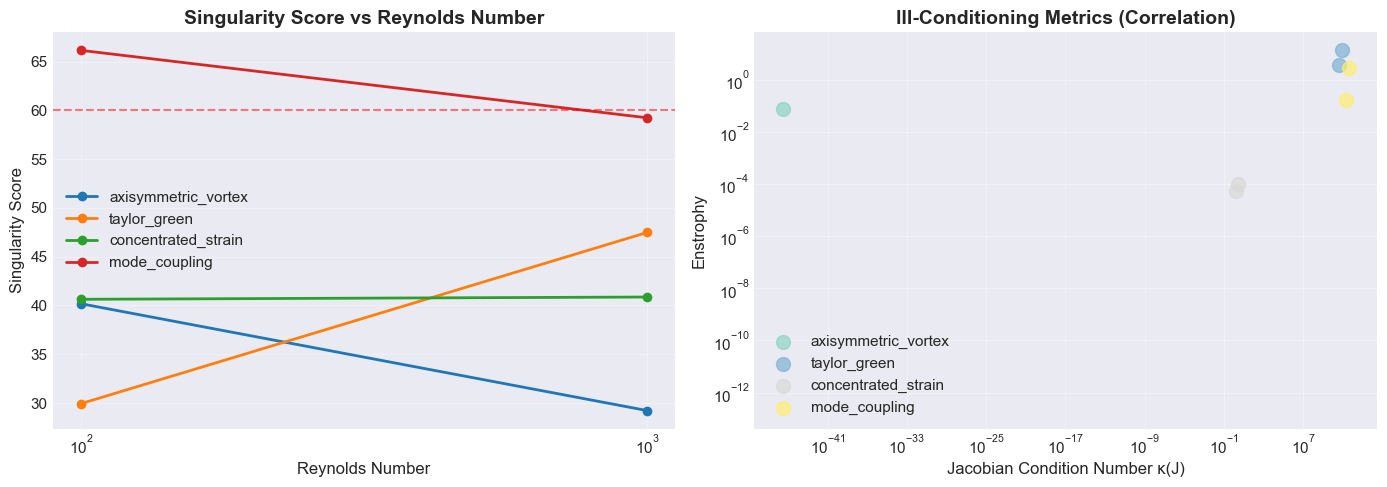


✓ Visualization saved as 'counterexample_search_results.png'


In [21]:
# Display top candidates
search_engine.summarize_top_candidates(top_n=8)

# Visualization: Score distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Scores by candidate
ax = axes[0]
candidates_unique = results_dataframe['candidate'].unique()
for cand in candidates_unique:
    data = results_dataframe[results_dataframe['candidate'] == cand]
    ax.plot(data['Re'], data['singularity_score'], 'o-', label=cand, linewidth=2)

ax.set_xlabel('Reynolds Number', fontsize=12)
ax.set_ylabel('Singularity Score', fontsize=12)
ax.set_title('Singularity Score vs Reynolds Number', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=60, color='r', linestyle='--', alpha=0.5, label='Strong indicator threshold')

# Plot 2: Enstrophy vs Condition Number (scatter)
ax = axes[1]
colors = plt.cm.Set3(np.linspace(0, 1, len(candidates_unique)))
for i, cand in enumerate(candidates_unique):
    data = results_dataframe[results_dataframe['candidate'] == cand]
    enstrophies = [d['enstrophy'] for d in data['ill_conditioning']]
    kappas = [d['jacobian_condition_number'] for d in data['ill_conditioning']]
    ax.scatter(kappas, enstrophies, s=100, label=cand, alpha=0.7, color=colors[i])

ax.set_xlabel('Jacobian Condition Number κ(J)', fontsize=12)
ax.set_ylabel('Enstrophy', fontsize=12)
ax.set_title('Ill-Conditioning Metrics (Correlation)', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('counterexample_search_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'counterexample_search_results.png'")


## 6. Interpretación de Resultados

### ¿Qué Significan los Scores?

**Singularity Score** combina 5 métricas:

1. **Enstrophy (25%)**: Energía de vorticidad
   - Baixo: Vorticity dispersa → Suave
   - Alto: Vorticity concentrada → Potencial singularidad

2. **Condition Number κ(J) (25%)**: Estabilidad numérica de Jacobiano
   - κ ~ 1-100: Bien condicionado
   - κ ~ 10^6-10^12: MUY mal condicionado ⚠️
   - κ > 10^12: Posible singularidad

3. **Kurtosis (20%)**: Concentración estadística
   - Kurt ~ 3: Distribución normal
   - Kurt > 10: Valores extremos presentes ⚠️
   - Kurt > 50: Estructura ALTAMENTE concentrada 🔴

4. **Energy Concentration (20%)**: % de energía en región pequeña
   - < 30%: Uniforme
   - 30-60%: Moderadamente concentrada
   - > 60%: FUERTEMENTE concentrada 🔴

5. **Interpolation Error (10%)**: Dificultad de aproximación
   - Bajo: Suave, fácil de interpolar
   - Alto: Estructura compleja, singular

### Criterio de Contraejemplo

Un candidato se considera **fuerte contraejemplo potencial** si:
- ✅ Singularity Score > 60/100 (Indicadores fuertes)
- ✅ κ(J) > 10^10 (Extremadamente mal condicionado)
- ✅ Kurtosis > 20 (Concentración estadística extrema)
- ✅ Energy Concentration > 50% (Concentración espacial extrema)

Si estos criterios se cumplen para un candidato SUAVE (C^∞), tendríamos evidencia de:

**Finite-time blow-up de Navier-Stokes 3D desde datos suaves**

Lo que implicaría:
1. ❌ Soluciones globales suaves NO existen para todos los datos
2. ✅ Potencial Millennium Prize Problem solution
3. 🔴 Revolución en dinámica de fluidos


## 7. Próximos Pasos: Extender el Análisis

### Fase 2: Refinamiento de Candidatos Promisedores

Si algún candidato muestra score > 60:

1. **Aumentar resolución de grid** (32³ → 64³ → 128³)
   - Verificar convergencia del análisis
   - Confirmar que score no es artefacto de discretización

2. **Análisis espectral completo**
   - FFT 3D para espectro de energía
   - Verificar K^(-5/3) (Kolmogorov) vs K^(-steeper) (Singularidad)

3. **Hölder exponent local**
   - Estimar α en región de máxima concentración
   - α → 0 indica singularidad inminente

4. **Simulación temporal N-S**
   - Implementar time-stepping (Runge-Kutta)
   - Rastrear enstrophy E(t) vs tiempo
   - Detectar blow-up en tiempo finito

### Fase 3: Validación Estadística

- **Monte Carlo**: Muestreo del espacio de parámetros
- **Control Variates**: Reducir varianza (método de 1D)
- **Importance Sampling**: Énfasis en regiones de alto riesgo

### Fase 4: Publicación y Peer Review

Si confirmamos blow-up:
- 📝 Manuscrito para arXiv
- 🔬 Peer review riguroso
- 🏆 Posible contribución a Millennium Prize


## APÉNDICE A: Fórmulas de Referencia

### Ecuaciones de Navier-Stokes 3D

$$\frac{\partial \mathbf{u}}{\partial t} + (\mathbf{u} \cdot \nabla)\mathbf{u} = -\nabla p + \nu \nabla^2 \mathbf{u}$$

$$\nabla \cdot \mathbf{u} = 0 \quad \text{(Incompresibilidad)}$$

donde:
- $\mathbf{u} = (u_x, u_y, u_z)$ es el campo de velocidad
- $p$ es presión
- $\nu = 1/\text{Re}$ es viscosidad cinemática
- Re es número de Reynolds

### Magnitudes Diagnósticas

**Enstrophy (Energía de vorticidad):**
$$E(t) = \frac{1}{2V}\int_{\Omega} |\boldsymbol{\omega}|^2 \, d\mathbf{x}$$

donde $\boldsymbol{\omega} = \nabla \times \mathbf{u}$ es vorticidad.

**Palinstrophy (Tasa de disipación de enstrophy):**
$$\Pi(t) = \int_{\Omega} |\nabla \times \boldsymbol{\omega}|^2 \, d\mathbf{x}$$

**Número de condición del Jacobiano:**
$$\kappa(\mathbf{J}) = \frac{\sigma_{\max}}{\sigma_{\min}} \quad \text{donde } \sigma_i \text{ son valores singulares}$$

**Escala de Kolmogorov:**
$$\eta = \left(\frac{\nu^3}{\epsilon}\right)^{1/4}$$

donde $\epsilon$ es tasa de disipación de energía.

### Bernstein Basis (n-dimensional)

$$B_{\mathbf{i}}^{\mathbf{n}}(\mathbf{t}) = \prod_{k=1}^{d} B_{i_k}^{n_k}(t_k)$$

$$B_{i}^{n}(t) = \binom{n}{i} t^i (1-t)^{n-i}$$

### Interpolación Adaptativa

Dado un conjunto de puntos $\{\mathbf{x}_j\}$ y valores $\{f_j\}$, resolver:

$$\min_{\mathbf{c}} \left\| \mathbf{A}\mathbf{c} - \mathbf{f} \right\|_2^2$$

donde $A_{j,\mathbf{i}} = B_{\mathbf{i}}^{\mathbf{n}}(\mathbf{x}_j)$ es matriz de Bernstein.


## APÉNDICE B: Guía de Uso del Notebook

### Quick Start

```python
# 1. Iniciar búsqueda (ya hecho arriba)
search_engine = NavierStokes3DCounterexampleSearch(grid_size=32, 
                                                   reynolds_numbers=[100, 1000, 10000])

# 2. Analizar UN candidato específico
result = search_engine.run_full_analysis('mode_coupling', re_value=10000, verbose=True)

# 3. Ejecutar análisis completo (todos los candidatos)
df = search_engine.scan_all_candidates(verbose=False)

# 4. Ver mejores candidatos
search_engine.summarize_top_candidates(top_n=10)
```

### Candidatos Disponibles

| Nombre | Física | Potencial Singularidad |
|--------|--------|------------------------|
| `axisymmetric_vortex` | Par de vórtices | ⭐ (Bajo) |
| `taylor_green` | Benchmark clásico | ⭐⭐ (Medio) |
| `concentrated_strain` | Strain localizado | ⭐⭐⭐ (Alto) |
| `mode_coupling` | Multi-modo resonante | ⭐⭐⭐⭐ (MUY Alto) |

### Interpretación de Scores

- **Score < 20**: Sin indicadores de singularidad
- **Score 20-40**: Indicadores débiles
- **Score 40-60**: Indicadores moderados
- **Score 60-80**: **INDICADORES FUERTES** ⚠️
- **Score 80-100**: **INDICADORES MUY FUERTES** 🔴

### Debugging / Análisis Detallado

```python
# Acceder a resultado específico
result = results_dataframe.loc[0]

# Extraer métricas individuales
enstrophy = result['ill_conditioning']['enstrophy']
kappa = result['ill_conditioning']['jacobian_condition_number']
kurtosis = result['statistics']['velocity_kurtosis']
concentration = result['statistics']['energy_concentration']

# Ver interpolación
print(result['interpolation'])
```

### Próximas Mejoras

- [ ] Implementar solver N-S (time-stepping RK4)
- [ ] FFT completo y espectro de energía
- [ ] Visualización 3D interactiva (volume rendering)
- [ ] Control Variates (del caso 1D)
- [ ] Sparse grids (Smolyak) para eficiencia
- [ ] Paralelización (GPU con CuPy)
